In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from comet_ml import Experiment
import os
import pickle
import configparser
np.random.seed(42)
from sklearn.metrics import confusion_matrix
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

In [2]:
config = configparser.ConfigParser()
config.read('../configfile.ini')
type_env = "comet_ml_prod" #comet_ml_prod
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME = config[type_env]['project_name_baseline']
COMET_WORKSPACE = config[type_env]['workspace']

comet_exp_obj = Experiment(api_key=COMET_API_KEY,
                           project_name=COMET_PROJECT_NAME,
                           workspace=COMET_WORKSPACE,
                           log_code=True
                          )
comet_exp_obj.set_name(name="Baseline Models")
comet_exp_obj.log_notebook("9_baseline_models_all.ipynb")

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/data-science-workspace/baseline-models/008194b834734bb98617ca621f27215b



{'web': 'https://www.comet.com/api/asset/download?assetId=c348ff5a9bc9440eb52f012a33308b7e&experimentKey=008194b834734bb98617ca621f27215b',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=c348ff5a9bc9440eb52f012a33308b7e&experimentKey=008194b834734bb98617ca621f27215b',
 'assetId': 'c348ff5a9bc9440eb52f012a33308b7e'}

In [3]:
def create_train_val_datafile():
    data = pd.read_pickle("../data/trainvaldata/train_set.pkl")
    data = data.dropna()
    print(data.shape)
    x_train, x_val, y_train, y_val = train_test_split(data, data["is_goal"], test_size=0.2, stratify=data["is_goal"], 
                                                          random_state=42)
    train_df = x_train.copy()
    train_df["is_goal"] = y_train
    train_df["train-val"] = 0

    val_df = x_val.copy()
    val_df["is_goal"] = y_val
    val_df["train-val"] = 1

    df = train_df.append(val_df, ignore_index=True)
    df.to_pickle("../data/trainvaldata/train_val_df.pkl") # Raphael use this and preprocess and share the x_train, y_train ....

# create_train_val_datafile()

In [4]:
x_train = pd.read_pickle("../data/trainvaldata/x_train.pkl")
x_val = pd.read_pickle("../data/trainvaldata/x_val.pkl")
y_train = pd.read_pickle("../data/trainvaldata/y_train.pkl")
y_val = pd.read_pickle("../data/trainvaldata/y_val.pkl")

comet_exp_obj.log_dataframe_profile(x_train, "x_train")
comet_exp_obj.log_dataframe_profile(y_train, "y_train")
comet_exp_obj.log_dataframe_profile(x_val, "x_val")
comet_exp_obj.log_dataframe_profile(y_val, "y_val")

x_train_df_distance = x_train[['distance']]
x_train_df_angle = x_train[['angle']]
x_train_df_distance_angle = x_train[['distance','angle']]
y_train = y_train.values

x_val_df_distance = x_val[['distance']]
x_val_df_angle = x_val[['angle']]
x_val_df_distance_angle = x_val[['distance','angle']]
y_val = y_val.values


data_train_dict = {
    "distance" : (x_train_df_distance, y_train, 1),
    "angle" : (x_train_df_angle, y_train, 1),
    "distance_angle" : (x_train_df_distance_angle, y_train, 2),
    "random_base_line" : ()
}

data_val_dict = {
    "distance" : (x_val_df_distance, y_val, 1),
    "angle" : (x_val_df_angle, y_val, 1),
    "distance_angle" : (x_val_df_distance_angle, y_val, 2),
    "random_base_line" : ()
}




COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring


In [5]:
def build_log_reg_model(model, x_val, y_val, no_of_features, k):
    if no_of_features == 1:
        x_val = x_val.values.reshape(-1, 1)
        
    y_pred = model.predict(x_val)
    accuracy = np.mean(y_val == y_pred) * 100
    print("correctly predicted / total is ", accuracy)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    metrics = {k + "_feature_accuracy":accuracy}
    classNames = np.unique(y_val)

    comet_exp_obj.log_metrics(metrics)
    comet_exp_obj.log_confusion_matrix(y_true=y_val, y_predicted=y_pred, title="Confusion Matrix for " + k,
                                      file_name="Confusion Matrix for " + k)

for k, v in data_train_dict.items():
    print("Classification Matrix for BaseLine Model for features - ", k)
    if k != "random_base_line":
        x_train = v[0]
        y_train = v[1]
        x_val = data_val_dict[k][0]
        y_val = data_val_dict[k][1]
        no_of_features = v[2]
        if no_of_features == 1:
            x_train = x_train.values.reshape(-1, 1)
        model = LogisticRegression()
        model.fit(x_train, y_train)
        build_log_reg_model(model, x_val, y_val, no_of_features, k)
        
        filename = '../model/' + k + "_model.pkl"
        pickle.dump(model, open(filename, 'wb'))
        comet_exp_obj.log_model(k, file_or_folder=filename, overwrite=True, file_name=k)
        
    else:
        y_pred = np.array([np.random.uniform(low=0.0, high=1.0) for i in range(y_val.shape[0])])
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0

        accuracy = np.mean(y_val == y_pred) * 100
        metrics = {k + "_feature_accuracy":accuracy}
        comet_exp_obj.log_metrics(metrics)
        print("correctly predicted / total is ", accuracy)
        print(classification_report(y_val, y_pred))
        comet_exp_obj.log_confusion_matrix(y_true=y_val, y_predicted=y_pred, title="Confusion Matrix for " + k,
                                      file_name="Confusion Matrix for " + k)

Classification Matrix for BaseLine Model for features -  distance
correctly predicted / total is  90.97315701955816
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     57445
           1       0.00      0.00      0.00      5700

    accuracy                           0.91     63145
   macro avg       0.45      0.50      0.48     63145
weighted avg       0.83      0.91      0.87     63145

[[57445     0]
 [ 5700     0]]
Classification Matrix for BaseLine Model for features -  angle
correctly predicted / total is  90.97315701955816
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     57445
           1       0.00      0.00      0.00      5700

    accuracy                           0.91     63145
   macro avg       0.45      0.50      0.48     63145
weighted avg       0.83      0.91      0.87     63145

[[57445     0]
 [ 5700     0]]
Classification Matrix for BaseLine Model for features -

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

              precision    recall  f1-score   support

           0       0.91      0.50      0.64     57445
           1       0.09      0.49      0.15      5700

    accuracy                           0.50     63145
   macro avg       0.50      0.50      0.40     63145
weighted avg       0.83      0.50      0.60     63145



COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor va

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor va

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING: Invalid y_predictor value 1.0, ignoring it
COMET WARNING: Invalid y_predictor value 0.0, ignoring it
COMET WARNING:

## Question 1

Evaluate the accuracy (i.e. correctly predicted / total) of your model on the validation set. What do you notice? Look at the predictions and discuss your findings. What could be a potential issue? Include these discussions in your blog post.

- Allthough the accuracy is showing up 90% of accuracy, but this number isn't right in my opion. As the major class is 0s, and the ratio of trainign data of shot being goal and not-goal is highly imbalance and is in the order of 1:10. 
- From the classificatinon report its clear that all the test data (validation data) has been predicted to 0s as the output. 


## Question 2
Receiver Operating Characteristic (ROC) curves and the AUC metric of the ROC curve. Include a random classifier baseline, i.e. each shot has a 50% chance of being a goal.

AUC ROC Scores for BaseLine Model for features -  distance
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.670
AUC ROC Scores for BaseLine Model for features -  angle
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.505
AUC ROC Scores for BaseLine Model for features -  distance_angle
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.670
AUC ROC Scores for BaseLine Model for features -  random_base_line
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.506


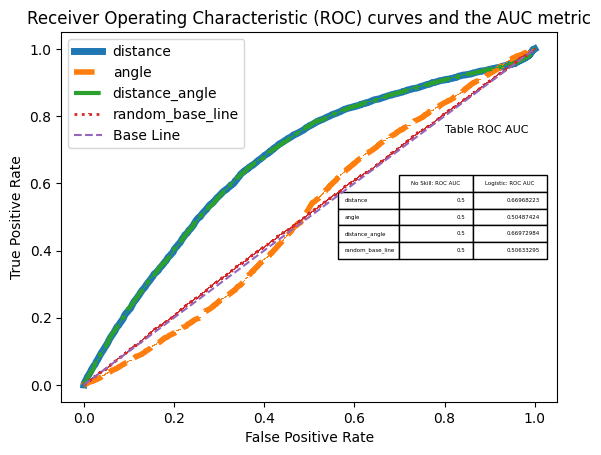

In [6]:
def create_roc_auc_curve(comet_exp_obj, model, x_val, y_val, no_of_features):    
    testy = y_val
    ns_probs = [0 for _ in range(len(testy))]
    
    predicted_probablities = model.predict_proba(x_val)
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = round(roc_auc_score(testy, goal_prob), 8)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, goal_prob)
    
    return ns_fpr, ns_tpr, lr_fpr, lr_tpr, ns_auc, lr_auc
    
    
plt.figure()    
table_values = []
markers_list = [",", ",", ",", ",", "P"]
for index, (k, v) in enumerate(data_train_dict.items()):
    lw=5-4*index/len(data_train_dict)
    ls=['-','--','-.',':'][index%4]
    print("AUC ROC Scores for BaseLine Model for features - ", k)
    if k != "random_base_line":
        x_train = v[0]
        y_train = v[1]
        x_val = data_val_dict[k][0]
        y_val = data_val_dict[k][1]
        no_of_features = v[2]
        if no_of_features == 1:
            x_train = x_train.values.reshape(-1, 1)
        model = LogisticRegression()
        model.fit(x_train, y_train)
        ns_fpr, ns_tpr, lr_fpr, lr_tpr, ns_auc, lr_auc = create_roc_auc_curve(comet_exp_obj, model, 
                                                                              x_val, y_val, no_of_features)
        table_values.append([ns_auc, lr_auc])
        # plot the roc curve for the model
        plt.plot(lr_fpr, lr_tpr, marker=markers_list[index], label=k, linewidth=lw, linestyle=ls)
    else:
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        y_pred = np.array([np.random.uniform(low=0.0, high=1.0) for i in range(y_val.shape[0])])
        goal_prob = y_pred
        
        ns_auc = roc_auc_score(testy, ns_probs)
        lr_auc = round(roc_auc_score(testy, goal_prob), 8)
        # summarize scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Logistic: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(testy, goal_prob)
        table_values.append([ns_auc, lr_auc])
        plt.plot(lr_fpr, lr_tpr, marker=markers_list[index], label=k, linewidth=lw, linestyle=ls)
    
# create_roc_auc_curve(comet_exp_obj, model, x_val, y_val, no_of_features)
col_labels=['No Skill: ROC AUC','Logistic: ROC AUC']
row_labels=[*data_train_dict]
table_vals=table_values
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.15]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
plt.text(0.8,0.75,'Table ROC AUC',size=8)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic (ROC) curves and the AUC metric")
plt.legend()
comet_exp_obj.log_figure(figure_name="Receiver Operating Characteristic (ROC) curves and the AUC metric", 
                             figure=plt, overwrite=False, step=None)
plt.show()


## Question 2
The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile, i.e. if a value is the 70th percentile, it is above 70% of the data. 

Goal Shot Rate for BaseLine Model for features -  distance
Goal Shot Rate for BaseLine Model for features -  angle
Goal Shot Rate for BaseLine Model for features -  distance_angle
Goal Shot Rate for BaseLine Model for features -  random_base_line


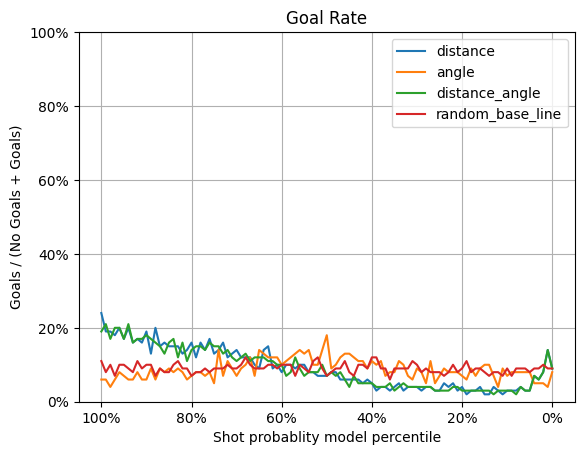

In [7]:
def plot_goal_shot_rate(plt1, model, x_val, y_val, k):
    testy = y_val
    ns_probs = [0 for _ in range(len(y_val))]
    predicted_probablities = model.predict_proba(x_val)
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = round((df.groupby(by='percentile_of_goal').sum() / 
                       df.groupby(by='percentile_of_goal').count())*100)
    goal_rate['percentile'] = goal_rate.index

    plt1.plot(goal_rate["percentile"], goal_rate["is_goal"], label=k)


fig, (plt1) = plt.subplots(1, 1)
for index, (k, v) in enumerate(data_train_dict.items()):
    print("Goal Shot Rate for BaseLine Model for features - ", k)
    if k != "random_base_line":
        x_train = v[0]
        y_train = v[1]
        x_val = data_val_dict[k][0]
        y_val = data_val_dict[k][1]
        no_of_features = v[2]
        if no_of_features == 1:
            x_train = x_train.values.reshape(-1, 1)
        model = LogisticRegression()
        model.fit(x_train, y_train)
        plot_goal_shot_rate(plt1, model, x_val, y_val, k)
        
    else:
        goal_prob = np.array([np.random.uniform(low=0.0, high=1.0) for i in range(x_val.shape[0])])
        df = pd.DataFrame(y_val, columns=["is_goal"])
        df["probablity_of_goal"] = goal_prob

        df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
        goal_rate = round((df.groupby(by='percentile_of_goal').sum() / 
                           df.groupby(by='percentile_of_goal').count())*100)
        goal_rate['percentile'] = goal_rate.index
        plt1.plot(goal_rate["percentile"], goal_rate["is_goal"], label=k)

plt1.set_ylim(0,100)
plt1.xaxis.set_major_formatter('{x:1.0f}%')
plt1.yaxis.set_major_formatter('{x:1.0f}%')
plt1.invert_xaxis()
plt1.set_xlabel('Shot probablity model percentile')
plt1.set_ylabel('Goals / (No Goals + Goals)')
plt.grid()
plt.title("Goal Rate")
plt.legend()
comet_exp_obj.log_figure(figure_name="Goal Rate", figure=fig,
                   overwrite=False, step=None)
plt.show()




Cumulative Goal for BaseLine Model for features -  distance
Cumulative Goal for BaseLine Model for features -  angle
Cumulative Goal for BaseLine Model for features -  distance_angle
Cumulative Goal for BaseLine Model for features -  random_base_line


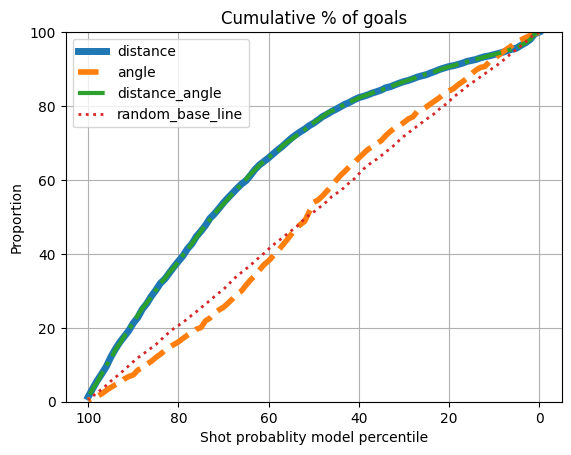

In [8]:
def plot_cumulative_goal(plt1, comet_exp_obj, model, x_val, y_val, k, ls, lw):
    testy = y_val
    ns_probs = [0 for _ in range(len(y_val))]
    
    predicted_probablities = model.predict_proba(x_val)

    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = df.groupby(by='percentile_of_goal').sum()
    goal_rate['percentile'] = goal_rate.index
    
    goal_rate['cum_sum'] = goal_rate.loc[::-1, 'is_goal'].cumsum()[::-1]
    goal_rate['cum_perc'] = 100*goal_rate['cum_sum'] / goal_rate['is_goal'].sum()
    
    plt1.plot(goal_rate["percentile"], goal_rate["cum_perc"], label=k, linewidth=lw, linestyle=ls)

graph, (plt1) = plt.subplots(1, 1)

for index, (k, v) in enumerate(data_train_dict.items()):
    print("Cumulative Goal for BaseLine Model for features - ", k)
    lw=5-4*index/len(data_train_dict)
    ls=['-','--','-.',':'][index%4]
    if k != "random_base_line":
        x_train = v[0]
        y_train = v[1]
        x_val = data_val_dict[k][0]
        y_val = data_val_dict[k][1]
        no_of_features = v[2]
        if no_of_features == 1:
            x_train = x_train.values.reshape(-1, 1)
        model = LogisticRegression()
        model.fit(x_train, y_train)
        plot_cumulative_goal(plt1, comet_exp_obj, model, x_val, y_val, k, ls, lw)
        
    else:
        ggoal_prob = np.array([np.random.uniform(low=0.0, high=1.0) for i in range(x_val.shape[0])])
        df = pd.DataFrame(y_val, columns=["is_goal"])
        df["probablity_of_goal"] = goal_prob

        df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
        goal_rate = df.groupby(by='percentile_of_goal').sum()
        goal_rate['percentile'] = goal_rate.index

        goal_rate['cum_sum'] = goal_rate.loc[::-1, 'is_goal'].cumsum()[::-1]
        goal_rate['cum_perc'] = 100*goal_rate['cum_sum'] / goal_rate['is_goal'].sum()
        plt1.plot(goal_rate["percentile"], goal_rate["cum_perc"], label=k, linewidth=lw, linestyle=ls)

plt1.set_ylim(0,100)
plt1.invert_xaxis()
plt1.set_xlabel('Shot probablity model percentile')
plt1.set_ylabel('Proportion')
plt.grid()
plt.title("Cumulative % of goals")
plt.legend()
comet_exp_obj.log_figure(figure_name="Cumulative % of goals", figure=plt,
                   overwrite=False, step=None)
    
plt.show()

Estimator Plot for BaseLine Model for features -  distance
Estimator Plot for BaseLine Model for features -  angle
Estimator Plot for BaseLine Model for features -  distance_angle
Estimator Plot for BaseLine Model for features -  random_base_line


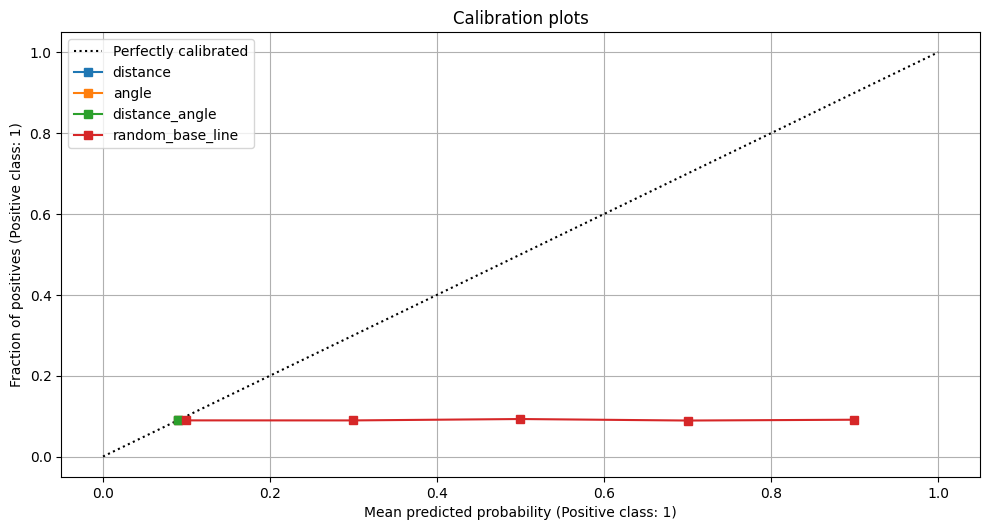

In [9]:
def create_extimator_plot(comet_exp_obj, model, x_val, y_val, k):
    testy = y_val
    ns_probs = [0 for _ in range(len(y_val))]
    
    predicted_probablities = model.predict_proba(x_val)
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    return CalibrationDisplay.from_predictions(y_val, goal_prob, ax=ax_calibration_curve,name=k)
#     return CalibrationDisplay.from_estimator(model, x_val, y_val, ax=ax_calibration_curve)
    
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for index, (k, v) in enumerate(data_train_dict.items()):
    print("Estimator Plot for BaseLine Model for features - ", k)
    if k != "random_base_line":
        x_train = v[0]
        y_train = v[1]
        x_val = data_val_dict[k][0]
        y_val = data_val_dict[k][1]
        no_of_features = v[2]
        if no_of_features == 1:
            x_train = x_train.values.reshape(-1, 1)
        model = LogisticRegression()
        model.fit(x_train, y_train)
        calibration_displays[k] = create_extimator_plot(comet_exp_obj, model, x_val, y_val, k)
        
    else:
        goal_prob = np.array([np.random.uniform(low=0.0, high=1.0) for i in range(x_val.shape[0])])
        calibration_displays[k] = CalibrationDisplay.from_predictions(y_val, goal_prob, ax=ax_calibration_curve, 
                                                                      name=k)

        
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
plt.tight_layout()
plt.legend(loc='upper left')

comet_exp_obj.log_figure(figure_name="Calibration Display", figure=plt,
                   overwrite=False, step=None)
comet_exp_obj.end()

plt.show()
    